In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
from ase import Atoms
from ase.io import read, write
from ase.calculators.dftb import Dftb
import sys, os

import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolTransforms import CanonicalizeMol, TransformConformer
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

In [3]:
from cgf.bnff import MikadoPotential, _energy_total, _get_phi0

In [4]:
# construct ase Atoms object from rdkit mol object
def mol2Atoms(mol, repr='2D'):
    AllChem.Compute2DCoords(mol)
    m2=Chem.AddHs(mol)
    
    if repr=='2D':
        # 2D coordinates
        AllChem.Compute2DCoords(m2)
    else:
        # or 3D
         AllChem.EmbedMolecule(m2)
         AllChem.UFFOptimizeMolecule(m2)
         CanonicalizeMol(m2, ignoreHs=False)
    
    c = m2.GetConformer(0)
    
    pos = c.GetPositions()

    nums = []
    for atom in c.GetOwningMol().GetAtoms():
        nums.append(atom.GetAtomicNum())

    return Atoms(positions=pos, numbers=nums)

# get natoms left/rightmost atoms
def get_left_right(atoms, natoms, ignoreHs=False):
    srt_indx = np.argsort(atoms.positions[:,0])
    left, right = list(srt_indx[0:natoms]), list(srt_indx[-natoms:])
    
    if ignoreHs:
        new_left = []
        for i in left:
            if atoms.numbers[i] > 1:
                new_left.append(i)
        new_right = []                
        for i in right:
            if atoms.numbers[i] > 1:
                new_right.append(i)
        left = new_left
        right = new_right
        
    return left, right

In [5]:
# rotation matrix: rotation around z
def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0],
                      [np.sin(radi), np.cos(radi), 0],
                      [0, 0, 1]], dtype=np.double)

# Redecorating

In [6]:
def w(x, phi0=0., phi1=0.):
    
    return (x**2 - 2*x + 1)*x*phi0 + (x - 1)*x**2*phi1

def dwdx(x, phi0=0., phi1=0.):
    
    return (3*x**2 - 4*x + 1)*phi0 + (3*x**2 - 2*x)*phi1

In [8]:
atoms = read('../test-data/TpDB_COF_1phenyl_SW_BNFF.xyz', format='extxyz')

smiles = 'B1(OC2=CC=CC=C2O1)C3=CC=C(C=C3)B4OC5=CC=CC=C5O4'
mol = Chem.MolFromSmiles(smiles)

s0 = mol2Atoms(mol, '3D')
left_ind, right_ind = get_left_right(s0, 2, ignoreHs=False)
del s0[left_ind + right_ind] # simply remove right/leftmost atoms

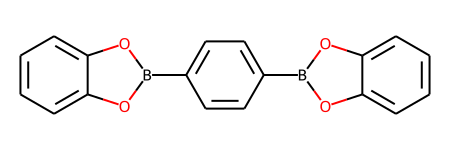

In [9]:
mol

In [16]:
phi0 = _get_phi0(atoms, 30.082740/np.sqrt(3))
phi0

array([5.75958442, 0.6269189 , 1.47462044, 6.21542758, 5.75958593,
       0.61977329, 2.1621435 , 0.61977932, 1.04719537, 2.16215387,
       5.78780508, 0.62692716, 5.75958526, 0.32127746, 5.7313657 ,
       0.33564255, 5.75958718, 0.32127519])

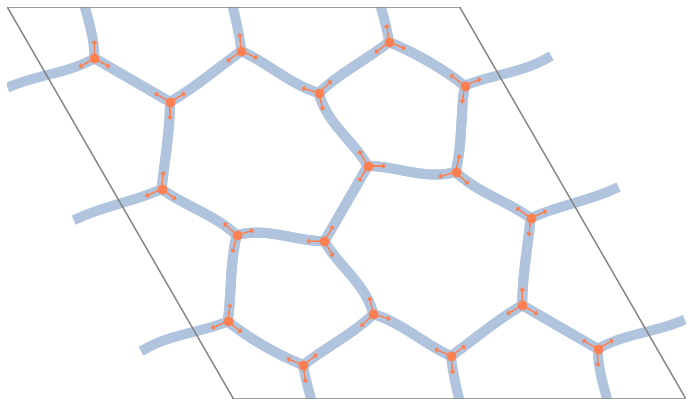

In [15]:
x = np.linspace(0,1,20)

phi0 = _get_phi0(atoms, 30.082740/np.sqrt(3))
r_c = atoms.positions
phi_c = atoms.get_initial_charges() + phi0

# find nearest neighbors
nn_c = []
for i in range(len(r_c)):
#     for j in range(i+1,len(r_c)):
    for j in range(len(r_c)):
        if i != j:
            for s1 in [-1,0,1]:
                for s2 in [-1,0,1]:
                    Rvec = s1 * atoms.cell.array[0,:] + s2 * atoms.cell.array[1,:]
                    if np.linalg.norm(r_c[i]-r_c[j] - Rvec) < 20.0:
                        nn_c.append([i,j,s1,s2])
#                        print(np.linalg.norm(r_c[i]-r_c[j]))


fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

# cores and directions of linking sites
ax.scatter(r_c[:,0],r_c[:,1], color='coral', marker='o', s=75, zorder=10)
for i in np.arange(len(r_c)):    
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]), 3*np.sin(phi_c[i]), color='coral', head_width=0.9, head_length=0.5, zorder=10)
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]+2*np.pi/3), 3*np.sin(phi_c[i]+2*np.pi/3), color='coral', head_width=0.9, head_length=0.5, zorder=10)
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]+4*np.pi/3), 3*np.sin(phi_c[i]+4*np.pi/3), color='coral', head_width=0.9, head_length=0.5, zorder=10)

# linkers as flexible beams
for i in np.arange(len(nn_c)):    
    Rvec = nn_c[i][2] * atoms.cell.array[0,:] + nn_c[i][3] * atoms.cell.array[1,:]
    
    r_ij = r_c[nn_c[i][1]] - r_c[nn_c[i][0]] + Rvec
    l_ij = np.linalg.norm(r_ij)
    r_ij = r_ij/l_ij
    r_ij_perp = np.cross(np.array([0,0,1.]), r_ij)
    phi_ij = np.mod(np.arctan2(r_ij[1], r_ij[0]), 2*np.pi)

    phi0s = np.array([(phi_c[nn_c[i][0]]-phi_ij),
                   np.mod(phi_c[nn_c[i][0]]+2*np.pi/3, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][0]]+4*np.pi/3, 2*np.pi)-phi_ij])
    phi0 = phi0s[0]
    if phi0 > np.pi:
        phi0 = phi0 - 2*np.pi

    for p in phi0s:    
        if p > np.pi:
            p = p - 2*np.pi
        if p < -np.pi:
            p = p + 2*np.pi

        if np.abs(p) < np.abs(phi0):
            phi0 = p

    phi1s = np.array([np.mod(phi_c[nn_c[i][1]]+np.pi, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][1]]+2*np.pi/3+np.pi, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][1]]+4*np.pi/3+np.pi, 2*np.pi)-phi_ij])
    phi1 = phi1s[0]
    if phi1 > np.pi:
        phi1 = phi1 - 2*np.pi

    for p in phi1s:    
        if p > np.pi:
            p = p - 2*np.pi
        if p < -np.pi:
            p = p + 2*np.pi

        if np.abs(p) < np.abs(phi1):
            phi1 = p
            
    r_bridge = np.array([r_c[nn_c[i][0]] + xi*l_ij*r_ij + w(xi, phi0, phi1)*l_ij*r_ij_perp for xi in x])
    ax.plot(r_bridge[:,0], r_bridge[:,1], color='lightsteelblue', lw=10)

ax.set_ylim((atoms.cell.array[:,1].min(),atoms.cell.array[:,1].max())) 
ax.set_xlim((atoms.cell.array[:,0].min(),atoms.cell.array[:,0].max())) 

# simulation cell
ax.plot([ 0., atoms.cell.array[0,0]], [0., atoms.cell.array[0,1]], color='grey')
ax.plot([ 0., atoms.cell.array[1,0]], [0., atoms.cell.array[1,1]], color='grey')
ax.plot([ atoms.cell.array[1,0], atoms.cell.array[1,0]+atoms.cell.array[0,0]], [atoms.cell.array[1,1], atoms.cell.array[1,1]+atoms.cell.array[0,1]], color='grey')
ax.plot([ atoms.cell.array[0,0], atoms.cell.array[1,0]+atoms.cell.array[0,0]], [atoms.cell.array[0,1], atoms.cell.array[1,1]+atoms.cell.array[0,1]], color='grey')

plt.tight_layout()
plt.axis('off')
plt.show()
#plt.savefig('COF-5_SW-schematic2.pdf')

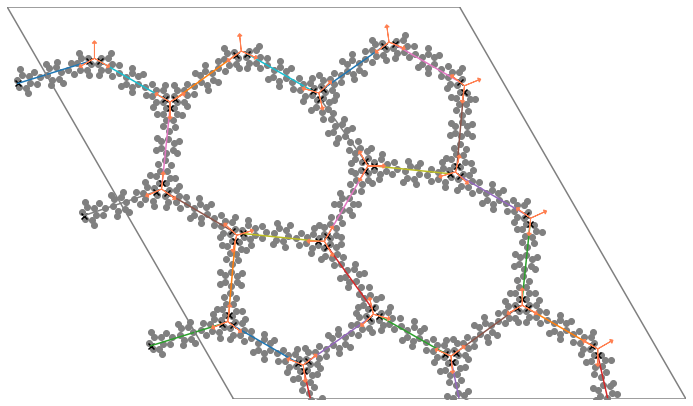

In [18]:
r_c = atoms.positions
phi0 = _get_phi0(atoms, 30.082740/np.sqrt(3))
phi_c = atoms.get_initial_charges() + phi0

### find nearest neighbors (incl. in neighboring cells)
nn_c = []
for i in range(len(r_c)):
#     for j in range(i+1,len(r_c)):
    for j in range(len(r_c)):
        if i != j:
            for s1 in [-1,0,1]:
                for s2 in [-1,0,1]:
                    Rvec = s1 * atoms.cell.array[0,:] + s2 * atoms.cell.array[1,:]
                    if np.linalg.norm(r_c[i]-r_c[j] - Rvec) < 20.0:
                        nn_c.append([i,j,s1,s2])
###


cof_atoms = Atoms(cell=atoms.cell, pbc=True)


fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

# cores and directions of linking sites
#ax.scatter(r_c[:,0],r_c[:,1], color='coral', marker='o', s=75, zorder=10)
for i in np.arange(len(r_c)):    
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]), 3*np.sin(phi_c[i]), color='coral', head_width=0.9, head_length=0.5, zorder=10)
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]+2*np.pi/3), 3*np.sin(phi_c[i]+2*np.pi/3), color='coral', head_width=0.9, head_length=0.5, zorder=10)
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]+4*np.pi/3), 3*np.sin(phi_c[i]+4*np.pi/3), color='coral', head_width=0.9, head_length=0.5, zorder=10)

# linkers as flexible beams
for i in range(len(nn_c)):
    if nn_c[i][0] > nn_c[i][1]:
        continue
    Rvec = nn_c[i][2] * atoms.cell.array[0,:] + nn_c[i][3] * atoms.cell.array[1,:]
    
    r_ij = r_c[nn_c[i][1]] - r_c[nn_c[i][0]] + Rvec
    l_ij = np.linalg.norm(r_ij) # distance between centers of neighboring cores
    r_ij = r_ij/l_ij
    r_ij_perp = np.cross(np.array([0,0,1.]), r_ij)
    phi_ij = np.mod(np.arctan2(r_ij[1], r_ij[0]), 2*np.pi)

    phi0s = np.array([(phi_c[nn_c[i][0]]-phi_ij),
                   np.mod(phi_c[nn_c[i][0]]+2*np.pi/3, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][0]]+4*np.pi/3, 2*np.pi)-phi_ij])
    phi0 = phi0s[0]
    if phi0 > np.pi:
        phi0 = phi0 - 2*np.pi

    for p in phi0s:    
        if p > np.pi:
            p = p - 2*np.pi
        if p < -np.pi:
            p = p + 2*np.pi

        if np.abs(p) < np.abs(phi0):
            phi0 = p

    phi1s = np.array([np.mod(phi_c[nn_c[i][1]]+np.pi, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][1]]+2*np.pi/3+np.pi, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][1]]+4*np.pi/3+np.pi, 2*np.pi)-phi_ij])
    phi1 = phi1s[0]
    if phi1 > np.pi:
        phi1 = phi1 - 2*np.pi

    for p in phi1s:    
        if p > np.pi:
            p = p - 2*np.pi
        if p < -np.pi:
            p = p + 2*np.pi

        if np.abs(p) < np.abs(phi1):
            phi1 = p
    
    # find the linking sites for the linker per core
    # this need to be generalized for other cores
    linker_0 = rot_ar_z(phi0) @ ((1.42/2)*np.tan(np.pi/3)*r_ij) + r_c[nn_c[i][0]]
    linker_1 = rot_ar_z(phi1) @ (-(1.42/2)*np.tan(np.pi/3)*r_ij) + r_c[nn_c[i][1]] + Rvec
    linker_01 = linker_1 - linker_0
    phi_01 = np.mod(np.arctan2(linker_01[1], linker_01[0]), 2*np.pi)
    
    ellij = np.linalg.norm(linker_01) # the linker is shorter than the distance between cores
                               
    
    ### transform linker according to fiber shape
    s = s0.copy()
    x0 = s.positions[:, 0].min()
    ell0 = ( s.positions[:,0].max()- s.positions[:,0].min() )
    for ati in range(len(s)):

        x = s.positions[ati, 0]
        y = s.positions[ati, 1]

        nx = -dwdx( (x-x0)/ell0, phi0, phi1)
        ny = 1.
        nn = np.sqrt(nx**2 + ny**2)
        nx = nx / nn
        ny = ny / nn
        
        # direction perpendicular to curve w(x) is [nx, ny]
        s.positions[ati, 0] = x0 + (x-x0)*(ellij/ell0) + y*nx
        s.positions[ati, 1] = ell0*w((x-x0)/ell0, phi0, phi1) + y*ny

    ### place linker at the center of vector connecting two cores
    ### and with correct orientation
    s.rotate(phi_01 * 180/np.pi, 'z')
    s.translate(linker_0 + linker_01/2)
    cof_atoms += s

    ax.scatter(s.positions[:,0], s.positions[:,1], c='grey')
    ax.scatter(linker_0[0], linker_0[1], marker='x', color='black')
    ax.scatter(linker_1[0], linker_1[1], marker='x', color='black')
    ax.plot([linker_0[0], linker_1[0]], [linker_0[1], linker_1[1]])
    ###

ax.set_ylim((atoms.cell.array[:,1].min(),atoms.cell.array[:,1].max())) 
ax.set_xlim((atoms.cell.array[:,0].min(),atoms.cell.array[:,0].max())) 

# simulation cell
ax.plot([ 0., atoms.cell.array[0,0]], [0., atoms.cell.array[0,1]], color='grey')
ax.plot([ 0., atoms.cell.array[1,0]], [0., atoms.cell.array[1,1]], color='grey')
ax.plot([ atoms.cell.array[1,0], atoms.cell.array[1,0]+atoms.cell.array[0,0]], [atoms.cell.array[1,1], atoms.cell.array[1,1]+atoms.cell.array[0,1]], color='grey')
ax.plot([ atoms.cell.array[0,0], atoms.cell.array[1,0]+atoms.cell.array[0,0]], [atoms.cell.array[0,1], atoms.cell.array[1,1]+atoms.cell.array[0,1]], color='grey')

plt.tight_layout()
plt.axis('off')
plt.show()
#plt.savefig('COF-5_SW-schematic2.pdf')

In [19]:
cof_atoms

Atoms(symbols='C486H216B54O108', pbc=True, cell=[[90.2481003, 0.0, 0.0], [-45.1240501, 78.1571503, 0.0], [0.0, 0.0, 30.0]])